In [1]:
###Load Packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [25]:
###Define useful functions
#transform xlsx to dataframe
def xlsx_to_csv_pd(path):
    data_train = pd.read_excel(path + '15.xlsx')
    xls_16 = pd.read_excel(path + '16.xlsx')
    xls_17 = pd.read_excel(path + '17.xlsx')
    data_train = pd.concat([data_train,xls_16,xls_17])
    data_test = pd.read_excel(path + '18.xlsx')
    return data_train, data_test

def x_y_split(df):
    y = df.pop('Comb Unrd Adj FE - Conventional Fuel')
    return df,y

def choose_column(df):
    count = df.shape[0] - df.count()
    filtered =  count[count < len(df)*0.2]
    index = list(filtered.index)
    index = [col for col in index if col.find('EPA') == -1 and col.find('FE') == -1 and col.find('MPG') == -1 and col.find('CO2') == -1 and col.find('Smog') == -1 and col.find('Guzzler') == -1 and col.find('Release Date') == -1 and col.find('Mfr Name') == -1 and col.find('Verify Mfr Cd') == -1]
    index = [col for col in index if col.find('Desc') == -1 or col.find('Calc Approach Desc') > -1 or col.find('Var Valve Timing Desc') > -1]    
    return df[index], index

#def choose_column_noDesc(df):
#    count = df.shape[0] - df.count()
#    filtered =  count[count < len(df)*0.2]
#    index = list(filtered.index)
#    index = [col for col in index if col.find('EPA') == -1 and col.find('FE') == -1 and col.find('MPG') == -1 and col.find('CO2') == -1 and col.find('Smog') == -1 and col.find('Guzzler') == -1 and col.find('Release Date') == -1 and col.find('Mfr Name') == -1 and col.find('Verify Mfr Cd') == -1]
#    index = [col for col in index if col.find('Desc') == -1 or col.find('Calc Approach Desc') > -1 or col.find('Var Valve Timing Desc') > -1]
#    return df[index], index

#def fillna_mean(dfo,index,dfto):
#    df = dfo.copy()
#    dft = dfto.copy()
#    for col in index:
#        if isinstance(df[col][0],(int,float)):
#            df.loc[:,col] = df[col].fillna(df.mean()[col].tolist()[0]).tolist()
#            dft.loc[:,col] = dft[col].fillna(df.mean()[col].tolist()[0]).tolist()
#        else:
#            df.loc[:,col] = df[col].fillna(df.mode()[col].tolist()[0]).tolist()
#            dft.loc[:,col] = dft[col].fillna(df.mode()[col].tolist()[0]).tolist()
#    return df,dft

def fillna_mean(dfo,index,dfto):
    df = pd.DataFrame()
    dft = pd.DataFrame()
    cate = []
    num = []
    for col in index:
        if dfo[col][0].dtype == 'int64' or dfo[col][0].dtype == 'float64':
            df[col] = dfo[col].fillna(dfo.mean()[col])
            dft[col] = dfto[col].fillna(dfo.mean()[col])
            num.append(col)
        else:
            df[col] = dfo[col].fillna(dfo.mode()[col])
            dft[col] = dfto[col].fillna(dfo.mode()[col])
            cate.append(col)
    return df,dft,cate,num


def one_hot_encoding(train,test):
    full = pd.concat([train, test]) 
    extended = pd.get_dummies(full)
    boundry = len(train)
    train = extended[:boundry]
    test = extended[boundry:]
    return train, test

def rfimpute(df, full_df):
    """
    rfimpute imputes missing values in df using random forest regression.
    
    Input:
        df: a pandas data frame df with missing value, note that choosing
            columns must happen before imputing. 
        full_df: a pandas data frame with missing values filled using mean, 
                median or mode.
    Output: 
        a pandas data frame having the same dimension as df
    """
    rf_reg = RandomForestRegressor(n_estimators=100)
    rf_cla = RandomForestClassifier(n_estimators=100)
    X_imputed = full_df.copy()
    filtered_train = df.copy()
    
    for i in range(10):
        #print("Now loop "+str(i))
        X_imputed_dummies = pd.get_dummies(X_imputed)
        last = X_imputed_dummies.copy().as_matrix()
        for feature in range(filtered_train.shape[1]):
            feature_name = filtered_train.columns.values[feature]
            #print("Performing on feature "+feature_name)
            
            #inds_not_f are column numbers that do not belong to feature column in dummies df
            inds_not_f = np.array([col for col in range(X_imputed_dummies.shape[1])\
              if (feature_name + "_") not in X_imputed_dummies.columns.values[col]])
            if len(inds_not_f) == X_imputed_dummies.shape[1]: #means feature is numerical
                  inds_not_f = np.array([col for col in range(X_imputed_dummies.shape[1])\
              if (feature_name) not in X_imputed_dummies.columns.values[col]])
        
            f_missing = filtered_train.isnull()[feature_name].values
            if any(f_missing): 
            
                #Convert df's to numpy matrix
                filtered_train_colnames = filtered_train.columns.values
                filtered_train_dtypes_dict = filtered_train.dtypes.to_dict()
                filtered_train = filtered_train.as_matrix()
                X_imputed_colnames = X_imputed.columns.values
                X_imputed_dtypes_dict = X_imputed.dtypes.to_dict()
                X_imputed = X_imputed.as_matrix()
                X_imputed_dummies_colnames = X_imputed_dummies.columns.values
                X_imputed_dummies = X_imputed_dummies.as_matrix()
                
                if feature_name in X_imputed_dummies_colnames: #numerical columns
                    #print(feature_name + " is numerical")
                    rf_reg.fit(X_imputed_dummies[~f_missing][:, inds_not_f], filtered_train[~f_missing, feature])
                    X_imputed[f_missing, feature] = rf_reg.predict(
                            X_imputed_dummies[f_missing][:, inds_not_f])
                else: #for categorical a feature column
                    #print(feature_name + " is categorical")
                    LabEnc = LabelEncoder()
                    y = LabEnc.fit_transform(filtered_train[~f_missing, feature])
                    rf_cla.fit(X_imputed_dummies[~f_missing][:, inds_not_f], y)
                    rf_cla_predicted_Enc = rf_cla.predict(X_imputed_dummies[f_missing][:, inds_not_f])
                    rf_cla_predicted = LabEnc.inverse_transform(rf_cla_predicted_Enc)
                    X_imputed[f_missing, feature] = rf_cla_predicted
                #Convert numpy matrix back to df's
                filtered_train = pd.DataFrame(data = filtered_train, columns = filtered_train_colnames)
                filtered_train = filtered_train.astype(filtered_train_dtypes_dict)
                X_imputed = pd.DataFrame(data = X_imputed, columns = X_imputed_colnames)
                X_imputed = X_imputed.astype(X_imputed_dtypes_dict)
                X_imputed_dummies = pd.get_dummies(X_imputed)

            
        now = pd.get_dummies(X_imputed).as_matrix()
        if (np.linalg.norm(last - now)) < .5:
            return X_imputed
    return X_imputed

In [40]:
train, test = xlsx_to_csv_pd('/Users/duxuewei/Documents/sp2018/AML/My_Car_efficiency/')
#/Users/haikundu/Desktop/4995AML/hw3/
#/Users/duxuewei/Documents/sp2018/AML/My_Car_efficiency/
train_x, train_y = x_y_split(train)
test_x, test_y = x_y_split(test)
filtered_train, column_name = choose_column(train_x)
filtered_test = test[column_name]
full_train,full_test, cat_cols, num_cols = fillna_mean(filtered_train,column_name,filtered_test)

#fillna with random forest regression
full_train = rfimpute(filtered_train, full_train)
full_test = rfimpute(filtered_test, full_test)


#one hot encoding
ohe_train,ohe_test = one_hot_encoding(full_train, full_test)

#Standard Scaler
scaler = StandardScaler()
scaler.fit(ohe_train)
X_train_scaled = scaler.transform(ohe_train)
X_test_scaled = scaler.transform(ohe_test)

In [41]:
#Random Forest Regression Model
rf_reg = RandomForestRegressor()

param_grid = {
                 'n_estimators': [5, 8, 11, 14],
                 'max_depth': [2, 4, 6, 8]
             }

grid_rf_reg = GridSearchCV(rf_reg, param_grid, cv=10)
grid_rf_reg.fit(X_train_scaled, train_y)
print("Best parameters for random forest regression model are "+str(grid_rf_reg.best_params_))
print("Best random forest training score using gridsearch is "+str(grid_rf_reg.best_score_))

Best parameters for random forest regression model are {'n_estimators': 14, 'max_depth': 8}
Best random forest training score using gridsearch is 0.967169599952


In [5]:
#Gradient Boosting
gbm_reg = GradientBoostingRegressor()

param_grid = {
                 'n_estimators':range(40,71,10), 
                 'max_depth':range(15,25,3), 
                 'min_samples_split':range(250,1250,300), 
                 'max_features':range(20,33,4) 
             }

grid_gbm_reg = GridSearchCV(gbm_reg, param_grid, cv=10)
grid_gbm_reg.fit(X_train_scaled, train_y)
print("Best parameters for gradient boosting model are "+str(grid_gbm_reg.best_params_))
print("Best gradient boosting training score using gridsearch is "+str(grid_gbm_reg.best_score_))

Best parameters for gradient boosting model are {'n_estimators': 70, 'max_depth': 21, 'min_samples_split': 250, 'max_features': 32}
Best gradient boosting training score using gridsearch is 0.959684977164


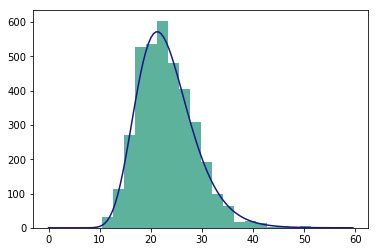

In [6]:
#How does y look like
from matplotlib import pyplot as plt
from scipy.stats import lognorm

plt.hist(train_y.values, bins=22, color = "#5cb29a")
scatter,loc,mean = lognorm.fit(train_y.values,
                               scale=train_y.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,60,.5),scatter,loc,mean)
plt.plot(np.arange(0,60,.5),7500*pdf_fitted,'r', color = "#161491")
plt.show()

In [26]:
train, test = xlsx_to_csv_pd('/Users/duxuewei/Documents/sp2018/AML/My_Car_efficiency/')
#/Users/haikundu/Desktop/4995AML/hw3/
#/Users/duxuewei/Documents/sp2018/AML/My_Car_efficiency/
train_x, train_y = x_y_split(train)
train_y = np.log(train_y)
test_x, test_y = x_y_split(test)
test_y = np.log(test_y)
filtered_train, column_name = choose_column(train_x)
filtered_test = test[column_name]
full_train,full_test, cat_cols, num_cols = fillna_mean(filtered_train,column_name,filtered_test)

#fillna with random forest regression
full_train = rfimpute(filtered_train, full_train)
full_test = rfimpute(filtered_test, full_test)


#one hot encoding
ohe_train,ohe_test = one_hot_encoding(full_train, full_test)

#Standard Scaler
scaler = StandardScaler()
scaler.fit(ohe_train)
X_train_scaled = scaler.transform(ohe_train)
X_test_scaled = scaler.transform(ohe_test)

In [35]:
#Random Forest Regression Model
rf_reg = RandomForestRegressor()

param_grid = {
                 'n_estimators': [5, 8, 11, 14],
                 'max_depth': [2, 4, 6, 8]
             }

grid_rf_reg = GridSearchCV(rf_reg, param_grid, cv=10)
grid_rf_reg.fit(X_train_scaled, train_y)
print("Best parameters for random forest regression model are "+str(grid_rf_reg.best_params_))
print("Best random forest training score using gridsearch is "+str(grid_rf_reg.best_score_))

Best parameters for random forest regression model are {'n_estimators': 8, 'max_depth': 8}
Best random forest training score using gridsearch is 0.970156555041


In [ ]:
#Gradient Boosting
gbm_reg = GradientBoostingRegressor()

param_grid = {
                 'n_estimators':range(40,71,10), 
                 'max_depth':range(15,25,3), 
                 'min_samples_split':range(250,1250,300), 
                 'max_features':range(20,33,4) 
             }

grid_gbm_reg = GridSearchCV(gbm_reg, param_grid, cv=10)
grid_gbm_reg.fit(X_train_scaled, train_y)
print("Best parameters for gradient boosting model are "+str(grid_gbm_reg.best_params_))
print("Best gradient boosting training score using gridsearch is "+str(grid_gbm_reg.best_score_))

Best parameters for gradient boosting model are {'n_estimators': 70, 'max_depth': 21, 'min_samples_split': 250, 'max_features': 32}
Best gradient boosting training score using gridsearch is 0.965020113475


In [36]:
##Best model
rf_best = grid_rf_reg.best_estimator_
rf_feature_importances = rf_best.feature_importances_
print("Model input Data has " + str(len(rf_feature_importances)) + " columns")
#ohe_train, ohe_test
rf_feature_importances_index = rf_feature_importances.argsort()[-30:][::-1]
print("Important columns are: " + str(ohe_train.columns.values[rf_feature_importances_index]))

Model input Data has 1662 columns
Important columns are: ['Eng Displ' 'Annual Fuel1 Cost - Conventional Fuel'
 'GHG Rating (1-10 rating on Label)_5'
 'GHG Rating (1-10 rating on Label)_4'
 'GHG Rating (1-10 rating on Label)_6'
 'GHG Rating (1-10 rating on Label)_3'
 'GHG Rating (1-10 rating on Label)_1' '# Cyl'
 'GHG Rating (1-10 rating on Label)_7'
 'GHG Rating (1-10 rating on Label)_2'
 'GHG Rating (1-10 rating on Label)_10'
 'Stop/Start System (Engine Management System) Code_Y' 'Model Year'
 'GHG Rating (1-10 rating on Label)_8'
 'GHG Rating (1-10 rating on Label)_9' 'Fuel Usage  - Conventional Fuel_G'
 'Fuel Usage  - Conventional Fuel_DU' 'Carline Class'
 'Index (Model Type Index)' 'Var Valve Lift?_Y'
 'Var Valve Timing Desc_Variable Valve Timing System with inlet'
 'Fuel Metering Sys Cd_CRDI' 'Var Valve Timing?_Y' 'Var Valve Lift?_N'
 'Unique Label?_N' 'Max Ethanol % - Gasoline'
 'Fuel Usage  - Conventional Fuel_GP' '# Gears'
 'Fuel Usage  - Conventional Fuel_GPR'
 'Var Valve Timi

In [37]:
##Test set performance
rf_test_score = rf_best.score(X_test_scaled, test_y)
print("Best random forest test score is "+ str(rf_test_score))

Best random forest test score is 0.946690694573


In [39]:
##Dropping irrelevant columns and run random forest w/ transformed y again
ohe_train = ohe_train[rf_feature_importances_index]
ohe_test = ohe_test[rf_feature_importances_index]
#Standard Scaler
scaler = StandardScaler()
scaler.fit(ohe_train)
X_train_scaled = scaler.transform(ohe_train)
X_test_scaled = scaler.transform(ohe_test)

rf_reg_best = RandomForestRegressor(n_estimators = 8, max_depth = 8)
rf_reg_best.fit(X_train_scaled, train_y)

print("Random Forest w/ log-transformed y dropping irrelevant columns has test set score " + str(rf_reg_best.score(X_test_scaled, test_y)))

Random Forest w/ log-transformed y dropping irrelevant columns has test set score 0.955005971143
